<a href="https://colab.research.google.com/github/vpriyanca/Prediction-Analysis/blob/main/Enrollment_Prediction_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import Libraries and Warnings Supression
import os
import tensorflow as tf
import statsmodels.api as sm
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Ignore specific warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Set TensorFlow logging level to ERROR
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [2]:
#Data Loading and Preprocessing
# Load the data
file_path = '/content/enrollment_data.xlsx'
student_demographic_df = pd.read_excel(file_path)

# Check for NaN values in FallTerm
if student_demographic_df['FallTerm'].isna().sum() > 0:
    print("NaN values found in FallTerm. Dropping rows with NaN values.")
    student_demographic_df = student_demographic_df.dropna(subset=['FallTerm'])

# Convert FallTerm to string, extract year, and convert to integer
student_demographic_df['Year'] = student_demographic_df['FallTerm'].astype(str).str[:4].astype(int)

# Create separate columns for each EthnicityCode
ethnicity_codes = ['A', 'B', 'F', 'H', 'M', 'N', 'P', 'W', 'X']
for code in ethnicity_codes:
    student_demographic_df[f'EthnicityCode_{code}'] = student_demographic_df['EthnicityCode'] == code

In [3]:
# Aggregate the data by year and calculate required features
student_demographic_df['FiscalYear'] = np.where(student_demographic_df['FallTerm'].astype(str).str[4:6].astype(int) < 7,
                                                 student_demographic_df['Year'] - 1,
                                                 student_demographic_df['Year'])

aggregated_data = student_demographic_df.groupby('FiscalYear').agg({
    'CountofStudents': 'sum',
    'Age': 'mean',
    'International': lambda x: (x == 'Y').mean(),  # proportion of international students
    'ResidencyCode': lambda x: (x == 'R').mean(),  # proportion of in-state students
    **{f'EthnicityCode_{code}': lambda x, code=code: x.mean() for code in ethnicity_codes}
}).reset_index()

# Extract the target variable
student_counts = aggregated_data[['FiscalYear', 'CountofStudents']].set_index('FiscalYear')

# Convert the index to a proper datetime format
student_counts.index = pd.to_datetime(student_counts.index.astype(str) + '-07-01', format='%Y-%m-%d')
student_counts.index.freq = 'AS-JUL'  # Set frequency to fiscal year start

# Calculate the rolling average with a window of 3 years
rolling_avg = student_counts.rolling(window=3, min_periods=1).mean()

In [4]:
#LSTM and ARIMA model Forecasting Functions
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Prebuild the LSTM model
input_shape = (2, 1)
lstm_model = build_lstm_model(input_shape)

def predict_and_validate_arima(train_start, train_end, predict_year):
    # Subset the data
    train_data = student_counts.loc[train_start:train_end]

    # Ensure enough data points for ARIMA
    if len(train_data) < 3:
        print(f"Not enough data to train the model for predicting {predict_year}. Skipping this prediction.")
        return None

    # Fit ARIMA model
    model = ARIMA(train_data, order=(1, 1, 1))
    model_fit = model.fit()

    # Forecast for the next year
    forecast = model_fit.forecast(steps=1)
    forecast_index = pd.to_datetime([f'{predict_year}-07-01'], format='%Y-%m-%d')
    forecast_series = pd.Series(forecast, index=forecast_index)

    # Extend the rolling average to include the forecast year
    rolling_avg_extended = rolling_avg.reindex(rolling_avg.index.union(forecast_index))
    rolling_avg_extended.iloc[-1] = rolling_avg.iloc[-1]

    # Print the forecasted value and compare with the actual value
    if predict_year <= 2023:
        actual_value = student_counts.loc[f'{predict_year}-07-01'].values[0]
        rolling_avg_value = rolling_avg.loc[f'{predict_year}-07-01'].values[0]
        forecast_value = forecast_series.iloc[0]
        difference = forecast_value - actual_value

        print(f"ARIMA - Year: {predict_year}")
        print(f"Actual student count: {actual_value}")
        print(f"Forecasted student count: {forecast_value}")
        print(f"Rolling Average: {rolling_avg_value}")
        print(f"Difference: {difference}\n")
    else:
        rolling_avg_value = rolling_avg_extended.loc[f'{predict_year}-07-01'].values[0]
        forecast_value = forecast_series.iloc[0]

        print(f"ARIMA - Year: {predict_year}")
        print(f"Forecasted student count: {forecast_value}")
        print(f"Rolling Average: {rolling_avg_value}\n")

    return forecast_series

def predict_and_validate_lstm(train_start, train_end, predict_year):
    # Prepare the data for LSTM
    train_data = student_counts.loc[train_start:train_end]

    if len(train_data) < 2:
        print(f"Not enough data to train the model for predicting {predict_year}. Skipping this prediction.")
        return None

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_train_data = scaler.fit_transform(train_data)

    # Create the data structure with 2 timesteps and 1 output
    X_train, y_train = [], []
    for i in range(2, len(scaled_train_data)):
        X_train.append(scaled_train_data[i-2:i, 0])
        y_train.append(scaled_train_data[i, 0])
    if len(X_train) == 0:  # If no data points are available
        print(f"Not enough data to create sequences for LSTM for predicting {predict_year}. Skipping this prediction.")
        return None
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshape data to [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # Train the LSTM model
    lstm_model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=0)

    # Prepare the input for prediction
    inputs = student_counts.loc[train_end:f'{predict_year}-07-01'].values
    if len(inputs) < 2:
        inputs = np.concatenate([inputs, inputs[-1:]], axis=0)
    inputs = scaler.transform(inputs)
    X_test = []
    X_test.append(inputs[-2:, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Make the prediction
    predicted_value = lstm_model.predict(X_test)
    predicted_value = scaler.inverse_transform(predicted_value)
    forecast_index = pd.to_datetime([f'{predict_year}-07-01'], format='%Y-%m-%d')
    forecast_series = pd.Series(predicted_value.flatten(), index=forecast_index)

    # Extend the rolling average to include the forecast year
    rolling_avg_extended = rolling_avg.reindex(rolling_avg.index.union(forecast_index))
    rolling_avg_extended.iloc[-1] = rolling_avg.iloc[-1]

    # Print the forecasted value and compare with the actual value
    if predict_year <= 2023:
        actual_value = student_counts.loc[f'{predict_year}-07-01'].values[0]
        rolling_avg_value = rolling_avg.loc[f'{predict_year}-07-01'].values[0]
        forecast_value = forecast_series.iloc[0]
        difference = forecast_value - actual_value

        print(f"LSTM - Year: {predict_year}")
        print(f"Actual student count: {actual_value}")
        print(f"Forecasted student count: {forecast_value}")
        print(f"Rolling Average: {rolling_avg_value}")
        print(f"Difference: {difference}\n")
    else:
        rolling_avg_value = rolling_avg_extended.loc[f'{predict_year}-07-01'].values[0]
        forecast_value = forecast_series.iloc[0]

        print(f"LSTM - Year: {predict_year}")
        print(f"Forecasted student count: {forecast_value}")
        print(f"Rolling Average: {rolling_avg_value}\n")

    return forecast_series

In [5]:
#Detailed Predictions
def print_detailed_predictions(year, data):
    # Print detailed predictions for the given year
    print(f"Predictions for {year}:")
    print(f"  Student Count: {data['CountofStudents']}")
    print(f"  Average Age: {data['Age']:.2f}")
    print(f"  International Students: {data['International']*100:.2f}%")
    print(f"  In-State Students: {data['ResidencyCode']*100:.2f}%")
    for code in ['A', 'B', 'F', 'H', 'M', 'N', 'P', 'W', 'X']:
        ethnicity_percentage = data[f'EthnicityCode_{code}'] if f'EthnicityCode_{code}' in data else 0
        print(f"  Students in Ethnicity Code {code}: {ethnicity_percentage*100:.2f}%")
    print("\n")

def forecast_detailed_2024(arima_prediction, lstm_prediction, historical_data):
    combined_prediction = (arima_prediction + lstm_prediction) / 2

    # Aggregate the historical data
    historical_data_2023 = historical_data.loc[historical_data['FiscalYear'] == 2023].iloc[0]

    # Apply the combined prediction to the historical proportions
    detailed_forecast = {
        'CountofStudents': combined_prediction,
        'Age': historical_data_2023['Age'],
        'International': historical_data_2023['International'],
        'ResidencyCode': historical_data_2023['ResidencyCode']
    }

    for code in ethnicity_codes:
        detailed_forecast[f'EthnicityCode_{code}'] = historical_data_2023[f'EthnicityCode_{code}']

    return detailed_forecast

ARIMA - Year: 2016
Actual student count: 40782
Forecasted student count: 41015.43802405653
Rolling Average: 41000.0
Difference: 233.43802405652968

ARIMA - Year: 2019
Actual student count: 37411
Forecasted student count: 38325.97088879909
Rolling Average: 38367.0
Difference: 914.9708887990928

ARIMA - Year: 2022
Actual student count: 33209
Forecasted student count: 34949.743844081255
Rolling Average: 34744.666666666664
Difference: 1740.7438440812548

ARIMA - Year: 2024
Forecasted student count: 33463.79579080413
Rolling Average: 33833.333333333336

1/1 [==============================] - 1s 788ms/step
LSTM - Year: 2016
Actual student count: 40782
Forecasted student count: 41002.75390625
Rolling Average: 41000.0
Difference: 220.75390625

1/1 [==============================] - 0s 24ms/step
LSTM - Year: 2019
Actual student count: 37411
Forecasted student count: 38315.8359375
Rolling Average: 38367.0
Difference: 904.8359375

1/1 [==============================] - 0s 20ms/step
LSTM - Year: 2

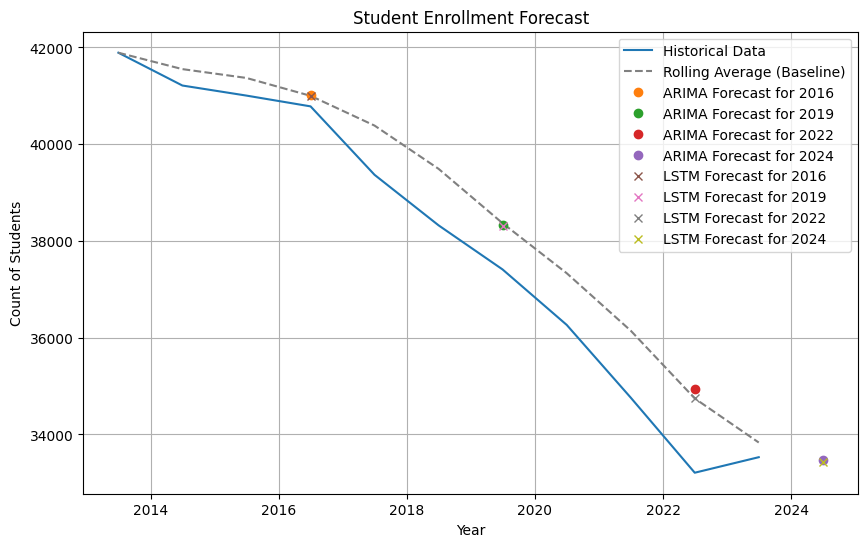

Predictions for 2016:
  Student Count: 40782.0
  Average Age: 24.59
  International Students: 6.66%
  In-State Students: 81.48%
  Students in Ethnicity Code A: 1.96%
  Students in Ethnicity Code B: 8.99%
  Students in Ethnicity Code F: 6.66%
  Students in Ethnicity Code H: 3.69%
  Students in Ethnicity Code M: 3.76%
  Students in Ethnicity Code N: 0.24%
  Students in Ethnicity Code P: 0.09%
  Students in Ethnicity Code W: 70.86%
  Students in Ethnicity Code X: 3.77%


Predictions for 2019:
  Student Count: 37411.0
  Average Age: 23.96
  International Students: 5.03%
  In-State Students: 81.95%
  Students in Ethnicity Code A: 2.38%
  Students in Ethnicity Code B: 9.33%
  Students in Ethnicity Code F: 5.03%
  Students in Ethnicity Code H: 4.45%
  Students in Ethnicity Code M: 4.22%
  Students in Ethnicity Code N: 0.18%
  Students in Ethnicity Code P: 0.10%
  Students in Ethnicity Code W: 70.55%
  Students in Ethnicity Code X: 3.77%


Predictions for 2022:
  Student Count: 33209.0
  Avera

In [6]:
#Visualisation and Plots
# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot historical data
plt.plot(student_counts, label='Historical Data')

# Plot rolling average
plt.plot(rolling_avg, label='Rolling Average (Baseline)', linestyle='--', color='grey')

# Validate predictions and plot ARIMA
forecast_arima_2016 = predict_and_validate_arima('2013-07-01', '2015-07-01', 2016)
forecast_arima_2019 = predict_and_validate_arima('2016-07-01', '2018-07-01', 2019)
forecast_arima_2022 = predict_and_validate_arima('2019-07-01', '2021-07-01', 2022)
forecast_arima_2024 = predict_and_validate_arima('2021-07-01', '2023-07-01', 2024)

# Validate predictions and plot LSTM
forecast_lstm_2016 = predict_and_validate_lstm('2013-07-01', '2015-07-01', 2016)
forecast_lstm_2019 = predict_and_validate_lstm('2016-07-01', '2018-07-01', 2019)
forecast_lstm_2022 = predict_and_validate_lstm('2019-07-01', '2021-07-01', 2022)
forecast_lstm_2024 = predict_and_validate_lstm('2021-07-01', '2023-07-01', 2024)

# Add forecasted values to the plot
if forecast_arima_2016 is not None:
    plt.plot(forecast_arima_2016, label='ARIMA Forecast for 2016', marker='o', linestyle='None')
if forecast_arima_2019 is not None:
    plt.plot(forecast_arima_2019, label='ARIMA Forecast for 2019', marker='o', linestyle='None')
if forecast_arima_2022 is not None:
    plt.plot(forecast_arima_2022, label='ARIMA Forecast for 2022', marker='o', linestyle='None')
if forecast_arima_2024 is not None:
    plt.plot(forecast_arima_2024, label='ARIMA Forecast for 2024', marker='o', linestyle='None')

if forecast_lstm_2016 is not None:
    plt.plot(forecast_lstm_2016, label='LSTM Forecast for 2016', marker='x', linestyle='None')
if forecast_lstm_2019 is not None:
    plt.plot(forecast_lstm_2019, label='LSTM Forecast for 2019', marker='x', linestyle='None')
if forecast_lstm_2022 is not None:
    plt.plot(forecast_lstm_2022, label='LSTM Forecast for 2022', marker='x', linestyle='None')
if forecast_lstm_2024 is not None:
    plt.plot(forecast_lstm_2024, label='LSTM Forecast for 2024', marker='x', linestyle='None')

# Add plot labels and legend
plt.xlabel('Year')
plt.ylabel('Count of Students')
plt.title('Student Enrollment Forecast')
plt.legend()
plt.grid(True)
plt.show()

# Print detailed predictions
for year in [2016, 2019, 2022, 2024]:
    if year in aggregated_data['FiscalYear'].values:
        detailed_data = aggregated_data[aggregated_data['FiscalYear'] == year].iloc[0]
        print_detailed_predictions(year, detailed_data)
    else:
        arima_forecast = forecast_arima_2024[0]
        lstm_forecast = forecast_lstm_2024[0]
        detailed_forecast_2024 = forecast_detailed_2024(arima_forecast, lstm_forecast, aggregated_data)
        print_detailed_predictions(year, detailed_forecast_2024)
